In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
csv_file_path = '/content/drive/MyDrive/train.csv'

df = pd.read_csv(csv_file_path)
print("Number of samples in dataset:", len(df))
# df = df.sample(n=1000, random_state=42)


# Step 2: Define image paths and labels
image_dir = {
    '0': '/content/drive/MyDrive/colored_images/No_DR',
    '1': '/content/drive/MyDrive/colored_images/Mild',
    '2': '/content/drive/MyDrive/colored_images/Moderate' ,
    '3': '/content/drive/MyDrive/colored_images/Severe',
    '4': '/content/drive/MyDrive/colored_images/Proliferate_DR'
}
image_paths = []
labels = []

# Assuming the CSV has 'filename' and 'label' columns
for idx, row in df.iterrows():
    filename = row['id_code']
    label = row['diagnosis']
    # Add .png extension to filename
    # Make sure the filenames in your CSV match the actual filenames in your folders, including the extension.
    image_path = os.path.join(image_dir[str(label)], filename + ".png")

    # Check if the image file actually exists
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(label)
    else:
        print(f"Warning: Image file not found: {image_path}")

# Step 3: Preprocess the images
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img) # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Convert images to numpy arrays
X = preprocess_images(image_paths)

# Convert labels to a numpy array and one-hot encode them
y = np.array(labels)
y = to_categorical(y, num_classes=5)  # 5 classes: 0 to 4

Number of samples in dataset: 3662


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
from tensorflow.keras.applications.efficientnet import preprocess_input

# After loading and resizing your images into arrays:
# X_train, X_val, X_test should be float32 and in range [0, 255]

# Optional: If not already float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
# X_test = X_test.astype('float32')

# Preprocess using EfficientNet's recommended preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
# X_test = preprocess_input(X_test)



In [ ]:
def create_transfer_model(input_shape=(224, 224, 3), fine_tune_at=200):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Enable fine-tuning

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy' , metrics=['accuracy'])

    return model

model = create_transfer_model()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 468ms/step - accuracy: 0.5777 - loss: 1.0986 - val_accuracy: 0.7449 - val_loss: 0.7343
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.7622 - loss: 0.6459 - val_accuracy: 0.7885 - val_loss: 0.5701
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7944 - loss: 0.5606 - val_accuracy: 0.8186 - val_loss: 0.5166
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8298 - loss: 0.4876 - val_accuracy: 0.8267 - val_loss: 0.4909
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8445 - loss: 0.4288 - val_accuracy: 0.8308 - val_loss: 0.5033
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8739 - loss: 0.3603 - val_accuracy: 0.8445 - val_loss: 0.4797
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8829 - loss: 0.3452 - val_accuracy: 0.8445 - val_loss: 0.4693
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8780 - loss: 0.3084 - val_accuracy: 0.83

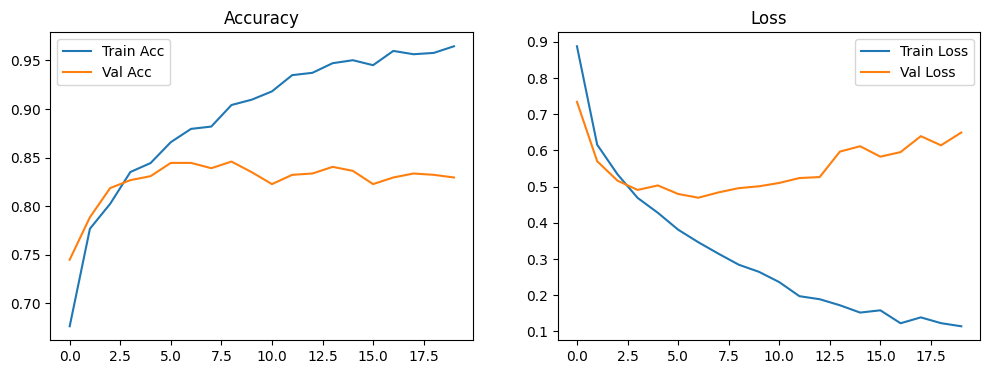

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)


In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8085 - loss: 0.7262
Validation Accuracy: 0.8295


In [ ]:
def get_grad_cam_heatmap(model, img_input):
    # Select the layer you want to visualize
    layer_name = 'efficientnetb0'  # Change to the correct layer name

    # Create a model that outputs the activations of the chosen layer
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Record the gradients with respect to the chosen layer and the output
        conv_output, predictions = grad_model(img_input)
        class_channel = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the feature maps by the pooled gradients
    conv_output = conv_output[0]
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging the weighted feature maps
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize the heatmap

    return heatmap


In [ ]:
def get_grad_cam_heatmap(model, image, last_conv_layer_name="efficientnetb0"):
    import tensorflow as tf
    import numpy as np

    # Get the EfficientNet base model
    efficientnet_layer = model.get_layer(name=last_conv_layer_name)

    # Find the last Conv2D layer inside the EfficientNet block
    conv_layers = [layer for layer in efficientnet_layer.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    if not conv_layers:
        raise ValueError("No Conv2D layer found in EfficientNet.")

    last_conv_layer = conv_layers[-1]  # the last conv layer in EfficientNet

    # Create a model that outputs activations from the last conv layer and the model output
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the conv outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
for layer in model.get_layer('efficientnetb0').layers:
    print(layer.name)


input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [38]:
print(X_train.shape)
print(X_val.shape)


(2929, 224, 224, 3)
(733, 224, 224, 3)


In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# Load and preprocess the image
# -------------------------------
def load_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, np.array(img)

# -------------------------------
# Get attention map (Grad-CAM)
# -------------------------------
def get_attention_map(model, img_array, last_conv_layer_name="top_activation"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap, int(pred_index.numpy())

# -------------------------------
# Overlay heatmap on original image
# -------------------------------
def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    superimposed_img = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img

# -------------------------------
# Main function
# -------------------------------
def visualize_attention(model, img_path, last_conv_layer_name='top_activation'):
    img_array, original_img = load_preprocess_image(img_path)
    heatmap, pred_class = get_attention_map(model, img_array, last_conv_layer_name)
    overlayed_img = overlay_heatmap(heatmap, original_img)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img.astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Attention Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay (Class {pred_class})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------
# Example usage
# -------------------------------
# Load your trained EfficientNet model
# Example: model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=True)

# Replace this with your model path or loaded model
# model = tf.keras.models.load_model('your_model.h5')
# visualize_attention(model, "path_to_retina_image.jpg")
